In [1]:
!pip install --upgrade transformers==4.51.3
!pip install --upgrade evaluate
!pip install --upgrade datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.


In [2]:
pip install tf-keras

In [3]:
!pip cache purge

Files removed: 42


In [4]:
import transformers
from transformers import TrainingArguments

print(transformers.__version__)
print(TrainingArguments.__init__.__doc__)

4.51.3
None


In [7]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from datasets import load_dataset
import pandas as pd
import numpy as np
import evaluate
from datasets import Dataset, DatasetDict

# model 과 tokenizer 불러오기
model_name = "klue/bert-base"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    ignore_mismatched_sizes=True,
    )

# data-set 로드(csv)
#dataset = load_dataset('csv', data_files='/content/final_dataset.csv')
train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("val.csv")

dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "validation": Dataset.from_pandas(val_df),
})
# 전처리 함수
def preprocess_function(examples):
    tokenized_inputs = tokenizer(examples["title"], padding='max_length', truncation=True)
    tokenized_inputs["labels"] = examples["label"]
    return tokenized_inputs
# 전처리
tokenized_dataset = dataset.map(preprocess_function, batched=True)

# 훈련설정
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    report_to="none",
    logging_steps=10,
    eval_steps=50,              # 몇 스텝마다 eval 할지 (steps일 경우)
    save_steps=50,              # 저장 주기도 맞춰주기
    save_total_limit=2
)
# 정확도 metric 불러오기
accuracy = evaluate.load("accuracy")

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)  # 로지츠(softmax 출력)에서 가장 큰 값 고르기

    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)

    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }
# 훈련
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    compute_metrics=compute_metrics,
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/572 [00:00<?, ? examples/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

Step,Training Loss
10,0.734200
20,0.691200
30,0.620000
40,0.508200
50,0.540600
60,0.429900
70,0.441400
80,0.301300
90,0.185400
100,0.129300


TrainOutput(global_step=360, training_loss=0.23705145998133553, metrics={'train_runtime': 329.5021, 'train_samples_per_second': 8.68, 'train_steps_per_second': 1.093, 'total_flos': 752497618329600.0, 'train_loss': 0.23705145998133553, 'epoch': 5.0})

In [8]:
!pip cache purge

Files removed: 0


In [9]:
print(trainer.evaluate())

{'eval_loss': 0.44769588112831116, 'eval_accuracy': 0.9097222222222222, 'eval_precision': 0.9163961038961039, 'eval_recall': 0.9021164021164021, 'eval_f1': 0.9069166127989658, 'eval_runtime': 4.0348, 'eval_samples_per_second': 35.689, 'eval_steps_per_second': 4.461, 'epoch': 5.0}


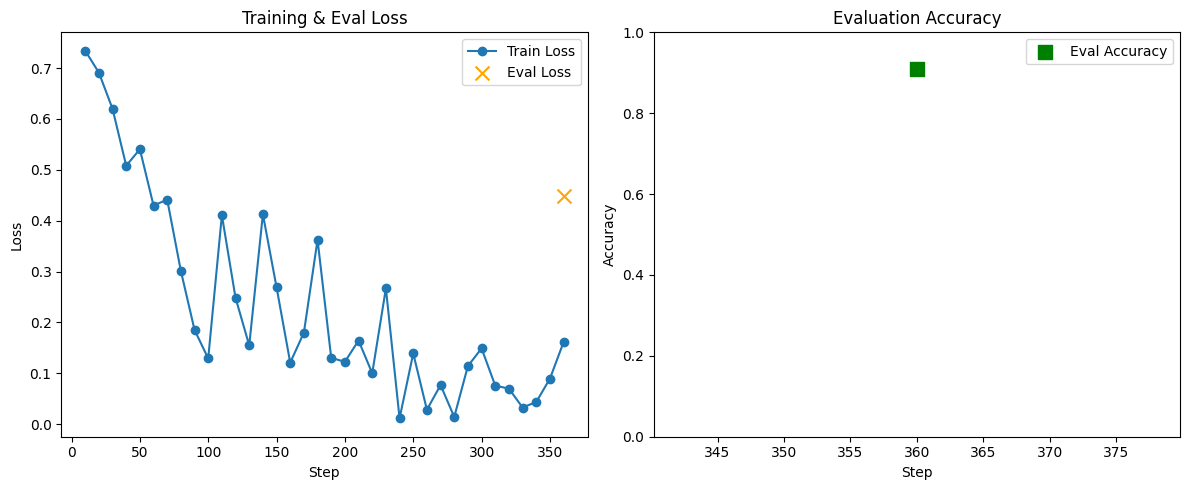

In [11]:
import matplotlib.pyplot as plt
import json

# trainer_state.json 열기
with open('./results/checkpoint-360/trainer_state.json', 'r', encoding='utf-8') as f:
    log_data = json.load(f)

log_history = log_data['log_history']

# Train Loss 불러오기
train_steps, train_loss = [], []

for entry in log_history:
    if 'loss' in entry:
        train_steps.append(entry['step'])
        train_loss.append(entry['loss'])

eval_result = trainer.evaluate()

eval_step = train_steps[-1]  # 가장 마지막 스텝 기준
eval_loss = eval_result['eval_loss']
eval_accuracy = eval_result['eval_accuracy']

# --- 그래프 그리기 ---
plt.figure(figsize=(12, 5))

# 1) Train Loss + Eval Loss
plt.subplot(1, 2, 1)
plt.plot(train_steps, train_loss, label='Train Loss', marker='o')
plt.scatter(eval_step, eval_loss, color='orange', label='Eval Loss', marker='x', s=100)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training & Eval Loss')
plt.legend()

# 2) Eval Accuracy
plt.subplot(1, 2, 2)
plt.scatter(eval_step, eval_accuracy, color='green', label='Eval Accuracy', marker='s', s=100)
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Evaluation Accuracy')
plt.ylim(0, 1)
plt.legend()

plt.tight_layout()
plt.show()



In [13]:
# 모델 저장
trainer.save_model("./my_model")
tokenizer.save_pretrained("./my_model")

('./my_model/tokenizer_config.json',
 './my_model/special_tokens_map.json',
 './my_model/vocab.txt',
 './my_model/added_tokens.json')

In [ ]:
# 모델 압축 해제
import os
import zipfile

zip_path = "/content/mymodel.zip"
model_path = "/content/mymodel"
# 폴더 없으면 생성
os.makedirs(model_path, exist_ok=True)
# 압축 풀기
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(model_path)


In [15]:
# 모델 불러오기
model_path="/content/my_model"
from transformers import BertTokenizer, BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained(model_path, local_files_only=True)
tokenizer = BertTokenizer.from_pretrained(model_path, local_files_only=True)

In [17]:
# 예측하기
model_path = "./my_model"
model = BertForSequenceClassification.from_pretrained(model_path, local_files_only=True)
tokenizer = BertTokenizer.from_pretrained(model_path, local_files_only=True)

text = "오늘의 급등주 ㅇㅇ회사 주가 상승 흐름.."

# 입력 전처리
input = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=512)

# 예측
output = model(**input)
logits = output.logits

#확률로 변환
import torch
probs = torch.softmax(logits, dim=1)

PRBBL_PSTV = probs[0][1].item()
PRBBL_NGTV = probs[0][0].item()
# 결과 출력
print(f"호재 확률: {PRBBL_PSTV:.2f}")
print(f"악재 확률: {PRBBL_NGTV:.2f}")

호재 확률: 1.00
악재 확률: 0.00
